# 12.3.5 - 12.3.8 カスタムレイヤ、カスタムモデル、自動微分

## 今回の目的
・カスタムレイヤ、カスタムモデル<br>
・損失や指標にモデルの内部状態を反映させる方法<br>
・自動微分を使った勾配の計算<br>

自動微分とは？:<br>
関数の実装をたどって、各初等関数をその微分に置き換え、合成関数の微分公式を適用していくことにより自動的に微分を行うこと

補足)<br>
微分の異なる手法として数値微分がある。<br>
数値微分は考え方が非常に単純で実装も簡単な手法だが、打切り誤差、丸め誤差が生ずる為、他の手法と比較して精度が低いという問題点がある。
また、微分したい関数の計算負荷が高いと、数値微分の計算負荷も高くなる。らしい。<br>

参考)<br>
https://atmarkit.itmedia.co.jp/ait/articles/2003/23/news024.html<br>
https://168iroha.net/blog/topic/?id=202007111957&sorting=post_date<br>
https://www.pwc.com/jp/ja/knowledge/column/viewpoint/grc-column003.html

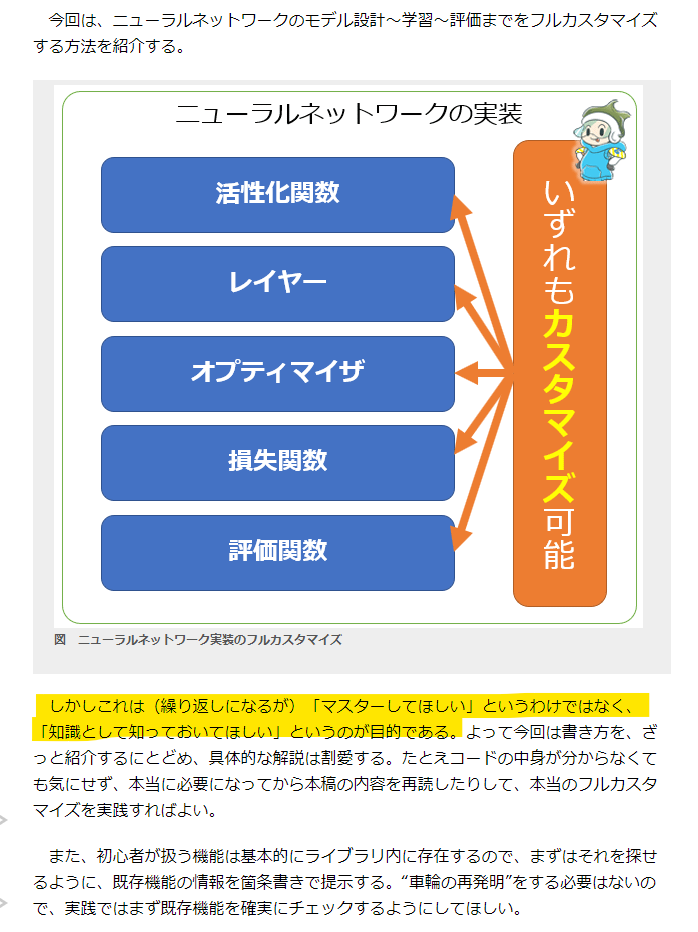

### セットアップ

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.4 is required in this notebook
# Earlier 2.x versions will mostly work the same, but with a few bugs
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.4"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
print('TensorFlow', tf.__version__)

TensorFlow 2.7.0


## 12.3.5　カスタムレイヤ

### 準備

まずはCalifornia housing datasetを読込んで準備しよう。<br>
読込んでからtrain, validation, testデータに分割し、スケーリングする。

In [3]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [4]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

In [5]:
exponential_layer([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787945, 1.        , 2.7182817 ], dtype=float32)>

In [6]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [10]:
input_shape = X_train.shape[1:]

In [11]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(1),
    exponential_layer
])
model.compile(loss="mse", optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/5
363/363 [==============================] - 1s 2ms/step - loss: 1.0631 - val_loss: 0.4457
Epoch 2/5
363/363 [==============================] - 0s 1ms/step - loss: 0.4562 - val_loss: 0.3798
Epoch 3/5
363/363 [==============================] - 1s 1ms/step - loss: 0.4029 - val_loss: 0.3548
Epoch 4/5
363/363 [==============================] - 0s 1ms/step - loss: 0.3851 - val_loss: 0.3464
Epoch 5/5
162/162 [==============================] - 0s 995us/step - loss: 0.3586


0.3586341142654419

In [12]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": keras.activations.serialize(self.activation)}

In [13]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [14]:
model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])

In [15]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 2.2563 - val_loss: 0.9472
Epoch 2/2
162/162 [==============================] - 0s 1ms/step - loss: 0.5474


0.5473727583885193

In [16]:
model.save("my_model_with_a_custom_layer.h5")

In [17]:
model = keras.models.load_model("my_model_with_a_custom_layer.h5",
                                custom_objects={"MyDense": MyDense})

In [18]:
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        print("X1.shape: ", X1.shape ," X2.shape: ", X2.shape) # Debugging of custom layer
        return X1 + X2, X1 * X2

    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape2]

In [19]:
inputs1 = keras.layers.Input(shape=[2])
inputs2 = keras.layers.Input(shape=[2])
outputs1, outputs2 = MyMultiLayer()((inputs1, inputs2))

X1.shape:  (None, 2)  X2.shape:  (None, 2)


In [20]:
def split_data(data):
    columns_count = data.shape[-1]
    half = columns_count // 2
    return data[:, :half], data[:, half:]

X_train_scaled_A, X_train_scaled_B = split_data(X_train_scaled)
X_valid_scaled_A, X_valid_scaled_B = split_data(X_valid_scaled)
X_test_scaled_A, X_test_scaled_B = split_data(X_test_scaled)

# Printing the splitted data shapes
X_train_scaled_A.shape, X_train_scaled_B.shape

((11610, 4), (11610, 4))

In [21]:
outputs1, outputs2 = MyMultiLayer()((X_train_scaled_A, X_train_scaled_B))

X1.shape:  (11610, 4)  X2.shape:  (11610, 4)


In [24]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

input_A = keras.layers.Input(shape=X_train_scaled_A.shape[-1])
input_B = keras.layers.Input(shape=X_train_scaled_B.shape[-1])
hidden_A, hidden_B = MyMultiLayer()((input_A, input_B))
hidden_A = keras.layers.Dense(30, activation='selu')(hidden_A)
hidden_B = keras.layers.Dense(30, activation='selu')(hidden_B)
concat = keras.layers.Concatenate()((hidden_A, hidden_B))
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

X1.shape:  (None, 4)  X2.shape:  (None, 4)


In [25]:
model.compile(loss='mse', optimizer='nadam')

In [26]:
model.fit((X_train_scaled_A, X_train_scaled_B), y_train, epochs=2,
          validation_data=((X_valid_scaled_A, X_valid_scaled_B), y_valid))

Epoch 1/2
X1.shape:  (None, 4)  X2.shape:  (None, 4)
X1.shape:  (None, 4)  X2.shape:  (None, 4)
363/363 [==============================] - 1s 2ms/step - loss: 2.1142 - val_loss: 1.3630
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.9684 - val_loss: 0.9773


In [27]:
class AddGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

In [28]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    AddGaussianNoise(stddev=1.0),
    keras.layers.Dense(30, activation="selu"),
    keras.layers.Dense(1)
])

In [29]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 2.3857 - val_loss: 7.6082
Epoch 2/2
162/162 [==============================] - 0s 904us/step - loss: 0.7560


0.7559615969657898

## 12.3.6　カスタムモデル

In [68]:
X_new_scaled = X_test_scaled

In [31]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu",
                                          kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

In [32]:
class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

In [33]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [34]:
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 2s 2ms/step - loss: 9.1325
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 1.0577
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.8865
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.5838
Epoch 5/5
162/162 [==============================] - 0s 1ms/step - loss: 0.6487


In [35]:
model.save("my_custom_model.ckpt")

INFO:tensorflow:Assets written to: my_custom_model.ckpt\assets


INFO:tensorflow:Assets written to: my_custom_model.ckpt\assets


In [36]:
model = keras.models.load_model("my_custom_model.ckpt")

In [37]:
history = model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
363/363 [==============================] - 3s 3ms/step - loss: 0.8208
Epoch 2/5
363/363 [==============================] - 1s 3ms/step - loss: 0.6615
Epoch 3/5
363/363 [==============================] - 1s 4ms/step - loss: 0.5120
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4372
Epoch 5/5
363/363 [==============================] - 1s 3ms/step - loss: 0.4785


In [38]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [39]:
block1 = ResidualBlock(2, 30)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    ResidualBlock(2, 30),
    keras.layers.Dense(1)
])

In [40]:
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 3s 3ms/step - loss: 0.8695
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 0.4720
Epoch 3/5
363/363 [==============================] - 1s 3ms/step - loss: 0.5537
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.3809
Epoch 5/5
162/162 [==============================] - 1s 3ms/step - loss: 0.4852


## 12.3.7 損失や指標にモデルの内部状態を反映させる方法

In [41]:
class ReconstructingRegressor(keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal")
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        self.reconstruction_mean = keras.metrics.Mean(name="reconstruction_error")

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = keras.layers.Dense(n_inputs)
        #super().build(batch_input_shape)

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        self.add_loss(0.05 * recon_loss)
        if training:
            result = self.reconstruction_mean(recon_loss)
            self.add_metric(result)
        return self.out(Z)

In [42]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [43]:
model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=2)
y_pred = model.predict(X_test_scaled)

Epoch 1/2
363/363 [==============================] - 4s 4ms/step - loss: 0.7885 - reconstruction_error: 1.0474
Epoch 2/2
363/363 [==============================] - 1s 3ms/step - loss: 0.4126 - reconstruction_error: 0.4022


## 12.3.8 自動微分を使った勾配の計算

In [44]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

In [45]:
w1, w2 = 5, 3
eps = 1e-6
(f(w1 + eps, w2) - f(w1, w2)) / eps

36.000003007075065

In [46]:
(f(w1, w2 + eps) - f(w1, w2)) / eps

10.000000003174137

In [47]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2])

In [48]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [49]:
with tf.GradientTape() as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
try:
    dz_dw2 = tape.gradient(z, w2)
except RuntimeError as ex:
    print(ex)

A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)


In [50]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
dz_dw2 = tape.gradient(z, w2) # works now!
del tape

In [51]:
dz_dw1, dz_dw2

(<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>)

In [52]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [53]:
gradients

[None, None]

In [54]:
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [55]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [56]:
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tape.gradient([z1, z2, z3], [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [57]:
with tf.GradientTape(persistent=True) as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tf.reduce_sum(tf.stack([tape.gradient(z, [w1, w2]) for z in (z1, z2, z3)]), axis=0)
del tape

In [58]:
with tf.GradientTape(persistent=True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape:
        z = f(w1, w2)
    jacobians = jacobian_tape.gradient(z, [w1, w2])
hessians = [hessian_tape.gradient(jacobian, [w1, w2])
            for jacobian in jacobians]
del hessian_tape

In [59]:
jacobians

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [60]:
hessians

[[<tf.Tensor: shape=(), dtype=float32, numpy=6.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.0>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=2.0>, None]]

In [61]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)

tape.gradient(z, [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

In [62]:
x = tf.Variable(100.)
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(), dtype=float32, numpy=nan>]

In [63]:
tf.math.log(tf.exp(tf.constant(30., dtype=tf.float32)) + 1.)

<tf.Tensor: shape=(), dtype=float32, numpy=30.0>

In [64]:
x = tf.Variable([100.])
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>]

In [65]:
@tf.custom_gradient
def my_better_softplus(z):
    exp = tf.exp(z)
    def my_softplus_gradients(grad):
        return grad / (1 + 1 / exp)
    return tf.math.log(exp + 1), my_softplus_gradients

In [66]:
def my_better_softplus(z):
    return tf.where(z > 30., z, tf.math.log(tf.exp(z) + 1.))

In [67]:
x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_better_softplus(x)

z, tape.gradient(z, [x])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1000.], dtype=float32)>,
 [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>])